In [44]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm #to create progress bar
import cv2 
import os

In [45]:
from google.colab import drive
drive.mount('/content/drive/') 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [47]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # 3 for Colored Images and 1 for Grayscale Images
BATCH_SIZE=32
EPOCHS= 30

In [48]:
class_names = ['Abnormal(Ulcer)',"Normal(Healthy skin)"]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

In [49]:
class_names_label

{'Abnormal(Ulcer)': 0, 'Normal(Healthy skin)': 1}

In [50]:
def load_data():
    datasets = ['/content/drive/MyDrive/DFUEffectiveNet Dataset/train', '/content/drive/MyDrive/DFUEffectiveNet Dataset/test']
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # Open and resize the img
                image = cv2.imread(img_path,cv2.IMREAD_COLOR)
                
                if image is None: # To account for broken images
                    continue
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)   

        output.append((images, labels))
    

    return output

In [51]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/drive/MyDrive/DFUEffectiveNet Dataset/train


100%|██████████| 1170/1170 [00:04<00:00, 278.58it/s]


Loading /content/drive/MyDrive/DFUEffectiveNet Dataset/test


100%|██████████| 170/170 [00:00<00:00, 301.20it/s]


In [52]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=1010)

In [53]:
print(train_labels.shape[0])
print(test_labels.shape[0])

2910
280


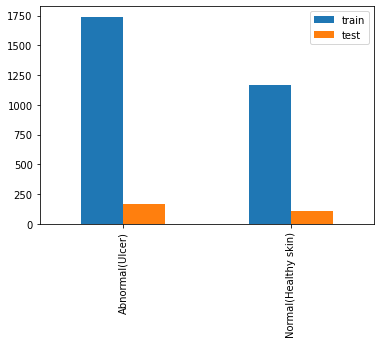

In [54]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

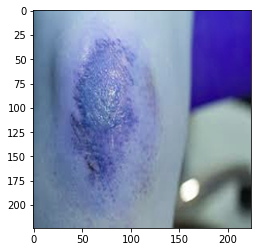

In [55]:
plt.imshow(random.choice(train_images))

In [56]:
train_labels=to_categorical(train_labels,2)
test_labels=to_categorical(test_labels,2)

In [57]:
train_labels[0:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [58]:
train_images.shape

(2910, 224, 224, 3)

In [59]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
import keras.backend as k
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [60]:
k.clear_session()
def inception_module(x, f1, f2, f3, f4):
		# 1x1 conv
		conv1 = keras.layers.Conv2D(f1, (1,1), strides=(1, 1), padding='same', activation='relu')(x)
		# 3x3 conv
		conv3 = keras.layers.Conv2D(f2, (3,3), strides=(1, 1), padding='same', activation='relu')(x)
		# 5x5 conv
		conv5 = keras.layers.Conv2D(f3, (5,5), strides=(1, 1), padding='same', activation='relu')(x)
		conv7 = keras.layers.Conv2D(f4, (7,7), strides=(1, 1), padding='same', activation='relu')(x)
		x = keras.layers.concatenate([conv1, conv3, conv5, conv7])
		return x

In [61]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

In [62]:
img_input = keras.Input(shape=(224, 224, 3))  #shape=(None, 299, 299, 3)

In [63]:
#OURmODELv6
#conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1))
x = conv2d_bn(img_input, 64, 7, 7, strides=(2, 2), padding='same') # 149 x 149 x 32
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

x = conv2d_bn(x, 64, 1, 1, padding='same')  # 147 x 147 x 32
x = conv2d_bn(x, 192, 3, 3, padding='same') # 147 x 147 x 64
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

#inception_module(x, f1, f2, f3)
x = inception_module(x, 128, 128, 128, 128)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 192, 192, 192, 192)
x = inception_module(x, 256, 256, 256, 256)
x = inception_module(x, 256, 256, 256, 256)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 512, 512, 512, 512)
x = keras.layers.MaxPooling2D((7, 7), strides=(1, 1))(x)  # 35 x 35 x 192

#x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)
x = Flatten()(x)
x = keras.layers.Dense(1000, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='softmax', name='predictions')(x) #shape=(None, 1000) 

In [ ]:
# Create model.
inputs = img_input
model =  keras.Model(inputs, x, name='DFUEffectiveNetV3')
model.summary()


Model: "DFUEffectiveNetV3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  192        ['conv2d[0][0]']                 
 alization)                     )                                                 

In [ ]:
earlystop = EarlyStopping(patience=10)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.00001)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator= train_datagen.flow(
    train_images, 
    train_labels,
    batch_size= BATCH_SIZE)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator= test_datagen.flow(test_images, test_labels,batch_size= BATCH_SIZE)

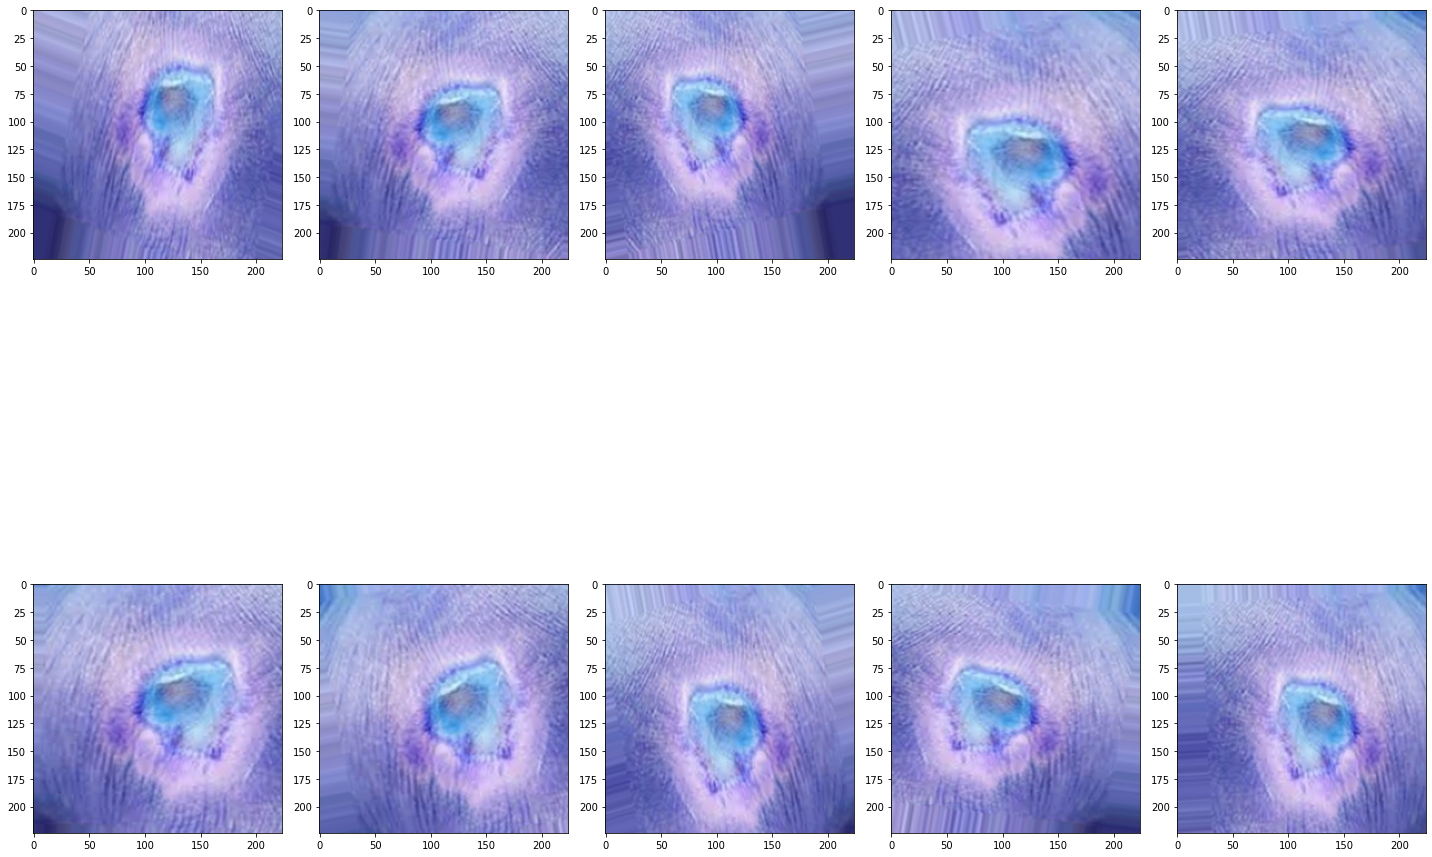

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    

augmented_images = [train_generator[0][0][0] for i in range(10)]
plotImages(augmented_images)


In [ ]:
model.compile(loss='binary_crossentropy', optimizer="rmsprop",metrics=['accuracy'])

In [ ]:
%%time
hist = model.fit(train_generator,
    epochs=EPOCHS,
    validation_data= test_generator,
    steps_per_epoch=train_images.shape[0]/BATCH_SIZE,
    callbacks=callbacks 
) 

In [ ]:
model.save('DFUEffectiveNetV3.h5')

#Load Model
#model3= keras.models.load_model("../input/model-v3/keras_30.h5")

In [ ]:
test_loss = model.evaluate(test_images, test_labels)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Training loss")
ax1.plot(hist.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

In [ ]:
#Reverse conversion from to_categorical
test_labels_vector = np.argmax(test_labels, axis = 1)

In [ ]:
cm = confusion_matrix(test_labels_vector, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_vector, pred_labels, target_names = class_names))

In [ ]:
def classification_evaluation(classification, predicted_labels, test_labels, test_images):
    if classification== "correct":
        indices_list = np.where(predicted_labels == test_labels)[0]
    else:
        indices_list = np.where(predicted_labels!= test_labels)[0]
    test_images_filtered= [test_images[i] for i in indices_list]
    images_labels_original= [test_labels[i] for i in indices_list]
    images_labels_predicted= [pred_labels[i] for i in indices_list]
    print(f"{len(test_images_filtered)} images were classified {classification.upper()} out of a total of {len(test_images)} in the Test dataset")

    unique, counts = np.unique(images_labels_original, return_counts=True)
    for i in range(0,len(unique)):
        print(f"for category {unique[i]} the number of {classification.upper()} classified images were: {counts[i]}")
        
    # Plot some of the misclassified images
    print("\n\n")
    fig,ax=plt.subplots(5,2)
    fig.suptitle(f"Sample of {classification.upper()} Classified Images", fontsize=20)
    fig.set_size_inches(15,15)
    for i in range(5):
        for j in range (2):
            l=random.randint(0,len(test_images_filtered))
            ax[i,j].imshow(test_images_filtered[l])
            ax[i,j].set_title("Predicted: "+str(images_labels_predicted[l])+"\n"+"Actual: "+str(images_labels_original[l]))
    plt.tight_layout()

In [ ]:
classification_evaluation("incorrect", pred_labels, test_labels_vector, test_images)

In [ ]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score

print('Accuracy: %.3f' % accuracy_score(test_labels_vector, pred_labels), 'Precision: %.3f' % precision_score(test_labels_vector, pred_labels),' Recall: %.3f' % recall_score(test_labels_vector, pred_labels), 
      'F1 Score: %.3f' % f1_score(test_labels_vector, pred_labels), 'AUC Score: %.3f' % roc_auc_score(test_labels_vector, pred_labels))



In [ ]:
specificity=TN/float(TN+FP)
print(specificity)